In [72]:
# config

additional_epochs = 2

In [73]:
import pickle

with open('epochs_last_time.pickle', 'rb') as f:
    epochs_last_time = pickle.load(f)

epochs_last_time

38

In [74]:
epochs_number = epochs_last_time + additional_epochs
epochs_number

40

In [75]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

data_dir = pathlib.Path("Plant_leave_diseases_dataset_with_augmentation")

image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

61484

In [76]:
my_batch_size = 32
img_height = 180
img_width = 180

In [77]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=my_batch_size,
)

Found 61486 files belonging to 39 classes.
Using 49189 files for training.


In [78]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=my_batch_size
)

Found 61486 files belonging to 39 classes.
Using 12297 files for validation.


In [79]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl

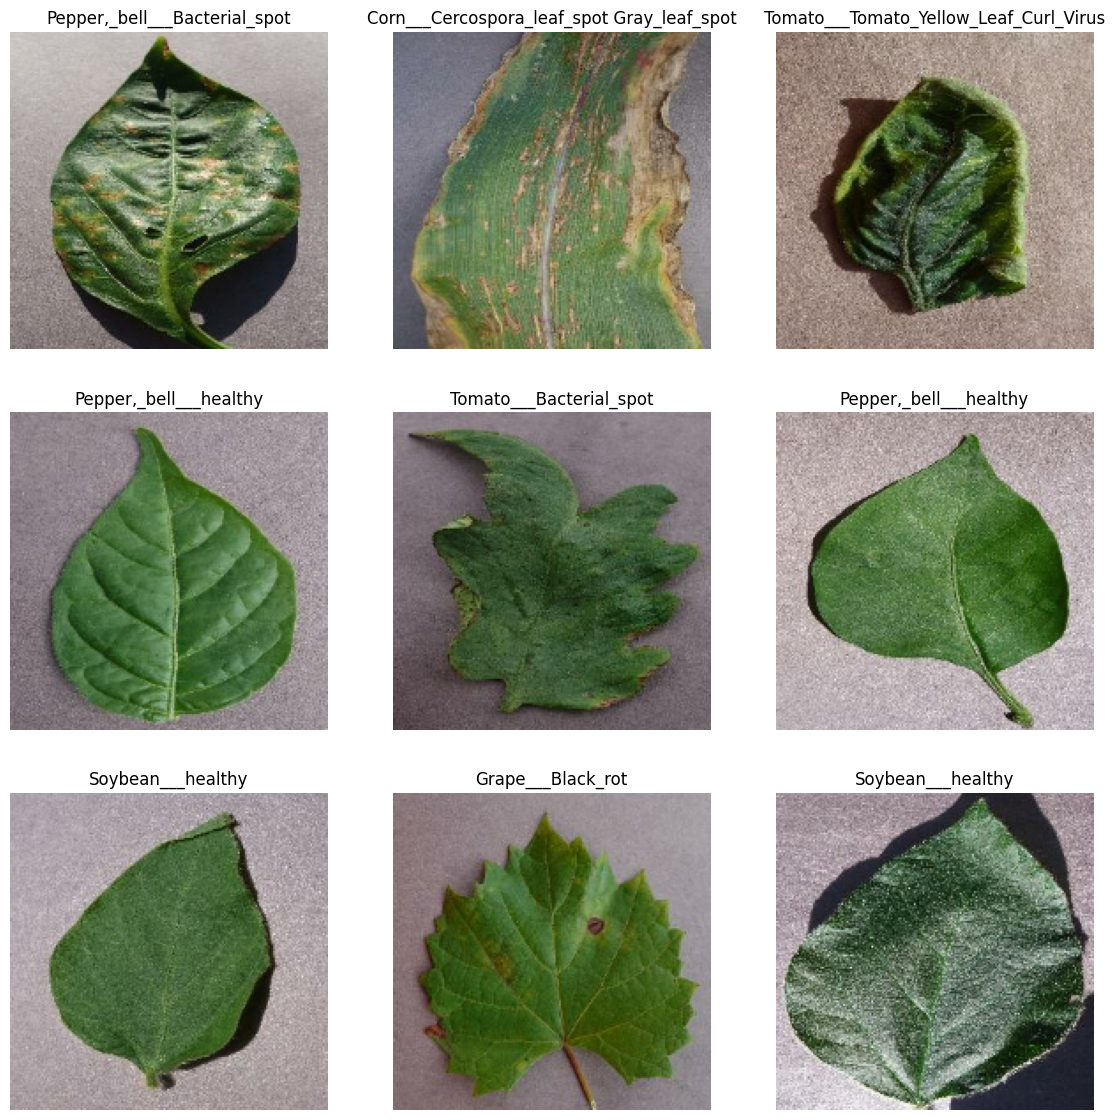

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [81]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1.0 / 255.0)

In [84]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# wartosci pikseli sa teraz w przedziale [0, 1]
print(np.min(first_image), np.max(first_image))

0.0 0.9833563


In [85]:
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1.0 / 255.0, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [88]:
def wykres_dla_modelu(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs_number)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [89]:
updated_model = tf.keras.models.load_model('zapisane_modele/model_%d_epok' % (epochs_last_time))

In [90]:
import pickle

for i in range(additional_epochs):
    with open('zapisane_modele/model_%d_epok/history.pkl' % (epochs_last_time + i), 'rb') as f:
        old_history = pickle.load(f)

    new_history = updated_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=1
    )

    current_epoch = epochs_last_time + i + 1

    updated_history = tf.keras.callbacks.History()
    updated_history.history = {}
    for key in old_history.history:
        updated_history.history[key] = old_history.history[key] + new_history.history[key]

    updated_model.save('zapisane_modele/model_%d_epok' % (current_epoch))

    with open('zapisane_modele/model_%d_epok/history.pkl' % (current_epoch), 'wb') as f:
        pickle.dump(updated_history, f)

    with open('epochs_last_time.pickle', 'wb') as f:
      pickle.dump(current_epoch, f)

1538/1538 [==============================] - 423s 270ms/step - loss: 0.0874 - accuracy: 0.9724 - val_loss: 0.1776 - val_accuracy: 0.9598


INFO:tensorflow:Assets written to: zapisane_modele/model_39_epok\assets


INFO:tensorflow:Assets written to: zapisane_modele/model_39_epok\assets


1538/1538 [==============================] - 382s 248ms/step - loss: 0.0878 - accuracy: 0.9730 - val_loss: 0.2267 - val_accuracy: 0.9475


INFO:tensorflow:Assets written to: zapisane_modele/model_40_epok\assets


INFO:tensorflow:Assets written to: zapisane_modele/model_40_epok\assets


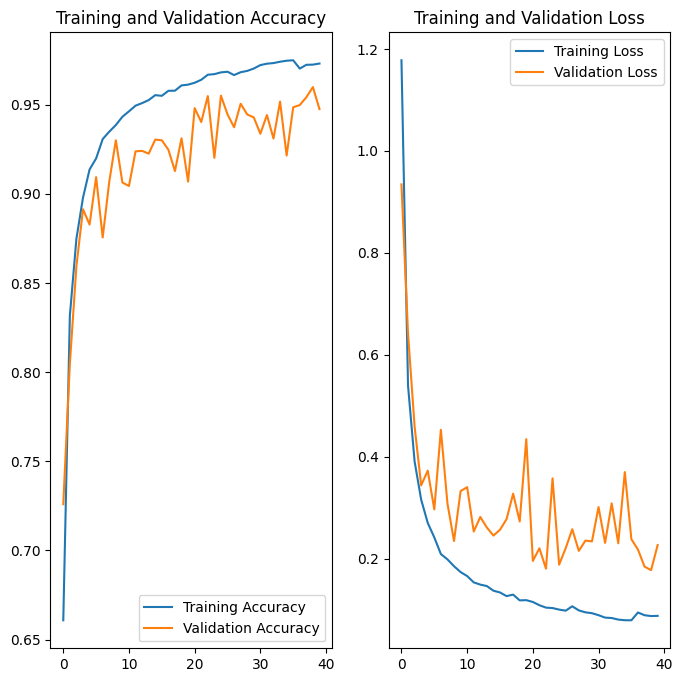

In [91]:
wykres_dla_modelu(updated_history)

In [92]:
# temp
import pandas as pd
history_df = pd.DataFrame(updated_history.history)

print(history_df)

        loss  accuracy  val_loss  val_accuracy
0   1.177776  0.660859  0.934247      0.725949
1   0.539488  0.831609  0.641355      0.804586
2   0.390645  0.874850  0.459336      0.859478
3   0.315770  0.897802  0.343770      0.891356
4   0.270171  0.913599  0.372690      0.882736
5   0.241653  0.919819  0.296672      0.909328
6   0.209056  0.930676  0.452832      0.875498
7   0.198669  0.934823  0.308213      0.906807
8   0.185201  0.938543  0.234760      0.929983
9   0.173736  0.943178  0.332518      0.906319
10  0.165895  0.946228  0.340249      0.904367
11  0.153516  0.949399  0.253211      0.923803
12  0.149139  0.950843  0.281815      0.924047
13  0.146285  0.952530  0.261124      0.922501
14  0.137168  0.955295  0.245337      0.930390
15  0.133709  0.954929  0.256725      0.929983
16  0.126573  0.957734  0.277641      0.924697
17  0.129460  0.957795  0.327591      0.912743
18  0.118222  0.960764  0.273025      0.931121
19  0.118635  0.961191  0.434522      0.906807
20  0.115082 